# Setup

In [1]:
# import packages
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import sklearn
import sys
import matplotlib
from tensorflow import keras
import datetime
import matplotlib.pyplot as plt

In [2]:
# import support libraries
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, \
                                                    img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D

In [3]:
print('Version check:')
print('Python: {}'.format(sys.version))
print('pandas: {}'.format(pd.__version__))
print('NumPy: {}'.format(np.__version__))
print('sklearn: {}'.format(sklearn.__version__))
print('matplotlib: {}'.format(matplotlib.__version__))
print('TensorFlow: {}'.format(tf.__version__))
print('Keras: {}'.format(keras.__version__))

Version check:
Python: 3.7.7 (default, Mar 26 2020, 15:48:22) 
[GCC 7.3.0]
pandas: 1.0.3
NumPy: 1.18.1
sklearn: 0.22.1
matplotlib: 3.1.3
TensorFlow: 2.2.0
Keras: 2.3.0-tf


In [4]:
# Backend Settings

# clear Keras session
keras.backend.clear_session()

# set seeds
np.random.seed(18)
tf.random.set_seed(18)

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
#tf.debugging.set_log_device_placement(True)

Num GPUs Available:  1


# Global functions

In [5]:
class TrainRuntimeCallback(keras.callbacks.Callback):

  def on_train_begin(self,logs={}):
    self.start = datetime.datetime.now()

  def on_train_end(self,logs={}):
    self.process_time = (datetime.datetime.now() - self.start).total_seconds()

In [6]:
class TestRuntimeCallback(keras.callbacks.Callback):

  def on_test_begin(self,logs={}):
    self.start = datetime.datetime.now()

  def on_test_end(self,logs={}):
    self.process_time = (datetime.datetime.now() - self.start).total_seconds()

# Load and import data

In [7]:
train_dir = 'data_files/train/'
test_dir = 'data_files/test/'

In [8]:
train_df = pd.read_csv('data_files/train.csv')
test_df = pd.read_csv('data_files/test.csv')

In [9]:
train_df = train_df.sort_values('filename')
test_df = test_df.sort_values('filename')

In [10]:
train_df.head()

,Unnamed: 0,id_code,experiment,plate,well,sirna,filename
0,0,HEPG2-01_1_B03,HEPG2-01,1,B03,513,HEPG2-01_1_B03_s1.jpeg
36515,36515,HEPG2-01_1_B03,HEPG2-01,1,B03,513,HEPG2-01_1_B03_s2.jpeg
1,1,HEPG2-01_1_B04,HEPG2-01,1,B04,840,HEPG2-01_1_B04_s1.jpeg
36516,36516,HEPG2-01_1_B04,HEPG2-01,1,B04,840,HEPG2-01_1_B04_s2.jpeg
2,2,HEPG2-01_1_B05,HEPG2-01,1,B05,1020,HEPG2-01_1_B05_s1.jpeg


In [11]:
test_df.head()

,Unnamed: 0,well_id,experiment,plate,well,filename,sirna_id
0,0,HEPG2-08_1_B03,HEPG2-08,1,B03,HEPG2-08_1_B03_s1.jpeg,855
19897,39794,HEPG2-08_1_B03,HEPG2-08,1,B03,HEPG2-08_1_B03_s2.jpeg,855
1,2,HEPG2-08_1_B04,HEPG2-08,1,B04,HEPG2-08_1_B04_s1.jpeg,710
19898,39796,HEPG2-08_1_B04,HEPG2-08,1,B04,HEPG2-08_1_B04_s2.jpeg,710
2,4,HEPG2-08_1_B05,HEPG2-08,1,B05,HEPG2-08_1_B05_s1.jpeg,836


# Preprocessing

## Subset development train/test set

In [12]:
num_classses = 20 # select 20 labels

sirna_subset = list(train_df[train_df.sirna <= 19].sirna.unique())
print(sirna_subset)
print(len(sirna_subset))

[6, 10, 8, 5, 3, 1, 2, 19, 11, 7, 4, 13, 14, 17, 18, 16, 0, 9, 15, 12]
20


In [13]:
len(sirna_subset)

20

In [14]:
type(sirna_subset[0])

numpy.int64

In [15]:
sm_train_df = train_df[train_df.sirna.isin(sirna_subset)].copy()
sm_test_df = test_df[test_df.sirna_id.isin(sirna_subset)].copy()

In [16]:
len(sm_train_df)

1320

In [17]:
len(sm_test_df)

720

In [18]:
test_cats = to_categorical(sirna_subset, 20, dtype='int')

## Change labels to categorical

In [19]:
y_train = np.array(sm_train_df.sirna)
y_test = np.array(sm_test_df.sirna_id)

y_train = to_categorical(y_train, 20)
y_test = to_categorical(y_test, num_classes = 20)

In [20]:
y_train.shape, y_test.shape

((1320, 20), (720, 20))

## Split some data into validation set

In [21]:
len(train_df)

73030

## Data preprocessing

In [22]:
img_height = 400
img_width = 400 

In [23]:
print(os.getcwd())
os.chdir('/home/specc/Documents/school_files/458_deep_learning/458_final_project/data_files/train')
print(os.getcwd())
print(os.listdir()[0])

/home/specc/Documents/school_files/458_deep_learning/458_final_project
/home/specc/Documents/school_files/458_deep_learning/458_final_project/data_files/train
RPE-06_2_E15_s1.jpeg


In [24]:
test_img_path = os.listdir()[5]
test_img = load_img(test_img_path)
x = img_to_array(test_img)
x.shape

(224, 224, 3)

In [25]:
os.chdir('/home/specc/Documents/school_files/458_deep_learning/458_final_project/data_files/train/')
len(os.listdir())

73030

In [26]:
train_datagen = ImageDataGenerator(rescale = 1./255)

test_datagen = ImageDataGenerator(
    rescale = 1./255
)

In [27]:
train_dir = '/home/specc/Documents/school_files/458_deep_learning/458_final_project/data_files/'
generator = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32
)

Found 112824 images belonging to 2 classes.


In [28]:
sm_train_df['sirna'] = sm_train_df.sirna.apply(lambda x: str(x))
sm_test_df['sirna_id'] = sm_test_df.sirna_id.apply(lambda x: str(x))

In [29]:
train_dir = '/home/specc/Documents/school_files/458_deep_learning/458_final_project/data_files/train/'

generator  = train_datagen.flow_from_dataframe(
    dataframe = sm_train_df,
    directory = train_dir,
    target_size = (224, 224),
    subset='training',
    x_col='filename',
    y_col='sirna',
    mode='categorical',
    color_mode='rgb',
    shuffle = True
)

Found 1320 validated image filenames belonging to 20 classes.


In [30]:
sample_training_images, _ = next(generator)

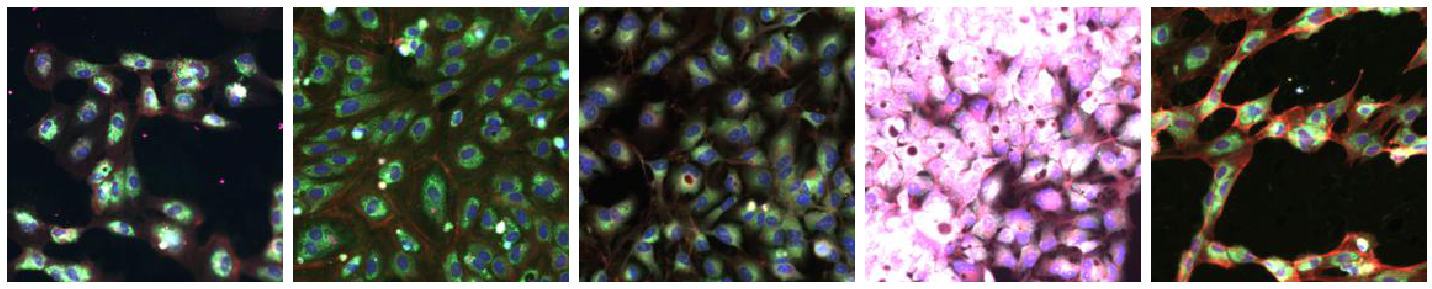

In [31]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

plotImages(sample_training_images[:5])

In [32]:
test_dir = '/home/specc/Documents/school_files/458_deep_learning/458_final_project/data_files/test/'

test_generator = test_datagen.flow_from_dataframe(
    dataframe = sm_test_df,
    directory = test_dir,
    target_size = (224, 224),
    x_col='filename',
    y_col='sirna_id',
    mode='categorical',
    color_mode='rgb'
)

Found 720 validated image filenames belonging to 20 classes.


In [33]:
model = Sequential()

model.add(Flatten())
model.add(Dense(64, activation='relu', input_shape = (224, 224, 3) ))
model.add(Dense(20, activation='softmax'))

#model.summary()

model.compile(
    optimizer='rmsprop',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

#model.summary()

In [34]:
model.fit_generator(
    generator = generator,
    steps_per_epoch = 20,
    epochs = 10
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
20/20 [==============================] - 1s 45ms/step - loss: 39.6800 - accuracy: 0.0531
Epoch 2/10
20/20 [==============================] - 1s 44ms/step - loss: 2.9939 - accuracy: 0.0516
Epoch 3/10
20/20 [==============================] - 1s 42ms/step - loss: 3.8843 - accuracy: 0.0503
Epoch 4/10
20/20 [==============================] - 1s 41ms/step - loss: 2.9947 - accuracy: 0.0531
Epoch 5/10
20/20 [==============================] - 1s 39ms/step - loss: 2.9959 - accuracy: 0.0341
Epoch 6/10
20/20 [==============================] - 1s 39ms/step - loss: 2.9918 - accuracy: 0.0484
Epoch 7/10
20/20 [==============================] - 1s 40ms/step - loss: 2.9928 - accuracy: 0.0601
Epoch 8/10
20/20 [==============================] - 1s 41ms/step - loss: 2.9950 - accuracy: 0.0500
Epoch 9/10
20/20 [==============================] - 1s 41ms/step - loss: 4.6990 - accuracy: 0.0519
Epoch 10/10
20/20 [=============

In [35]:
model = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(224, 224 ,3)),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(20, activation='softmax')
])


model.compile(
    optimizer='rmsprop',
    loss=tf.keras.losses.categorical_crossentropy,
    metrics=['accuracy']
)

In [36]:
model.fit_generator(
    generator = generator,
    steps_per_epoch = 20,
    epochs = 10
)

Epoch 1/10


UnknownError:  Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node sequential_1/conv2d/Conv2D (defined at <ipython-input-36-0eaf70411a78>:4) ]] [Op:__inference_train_function_2033]

Function call stack:
train_function
